In [67]:
# start with import statements as necessary

import numpy as np  # arithmetic
import photutils # photometry
from astropy.io import fits
from astropy.stats import mad_std
from photutils import DAOStarFinder  # finding stars on image
import matplotlib.pyplot as plt  # plotting tools
import glob  # gathering images

from photutils import find_peaks  # find bright sources in image
from photutils import centroid_com  # for center of mass centroids

This is test code to perform photometry on focuser files.

First, let's start with DAOStarFinder to perform photometry. Then we will try the centroid method.

In [68]:
def star_finder(images, fwhm):  # a function to perform photometry on one or more images
    image_list = glob.glob(images)  # gather images from folder
    # get the list in a stack
    stack = []

    # extract the data and header from the fits files
    for file in image_list:
        stack.append(fits.getdata(file).astype(np.int32))  # get the array data, put it in stack                                                 
        fits.getheader(file)  # preserve the header

    for file in stack:
        bkg_sigma = mad_std(file)
        daofind = DAOStarFinder(fwhm=fwhm, threshold=30.*bkg_sigma)
        sources = daofind(file)
        
        for col in sources.colnames:
            sources[col].info.format = '%.8g'
        print(sources)

In [69]:
star_finder('focus_files/2018.06.23/*.fits', 3)

 id xcentroid ycentroid sharpness   roundness1 ... sky  peak   flux     mag    
--- --------- --------- ---------- ----------- ... --- ----- ------- ----------
  1 105.89403 457.25235 0.43224692 -0.61263902 ...   0 19438 20.8119 -3.2957793
 id xcentroid ycentroid sharpness  roundness1 ... sky  peak    flux      mag    
--- --------- --------- ---------- ---------- ... --- ----- --------- ----------
  1 107.78386 458.01621 0.43899912 0.18902837 ...   0 19986 19.323147 -3.2151947
 id xcentroid ycentroid sharpness  roundness1 ... sky  peak    flux      mag    
--- --------- --------- ---------- ---------- ... --- ----- --------- ----------
  1 106.13933 455.53211 0.42357405 -0.1657643 ...   0 28027 26.389977 -3.5535975
 id xcentroid ycentroid sharpness  roundness1 ... sky  peak    flux      mag    
--- --------- --------- ---------- ---------- ... --- ----- --------- ----------
  1 105.21183 455.61742 0.46469266 0.24720848 ...   0 19176 14.596028 -2.9105867
 id xcentroid ycentroid sharpne

Looks like this code finds a few stars per image, which seems about right. If we open the images in DS9, we can see there are only a few bright points per image, so this makes sense.

Next, we can try the centroiding method, which finds the center of mass of a bright point on the image. Then we will plot where the centroids were found.

In [70]:
def find_centroid(images):  # function to find the centroids of bright points in a fits image
    imlist = glob.glob(images)
    
    for image in imlist:
        unflipped_data = fits.getdata(image).astype(np.int32)  # get the array of pixel data
        data = np.flip(unflipped_data, axis=0)  # flip to get axis correct orientation
        bkg_sigma = mad_std(data)  # for the threshold calculation, next line
        sources = find_peaks(data=data, threshold=80.*bkg_sigma, box_size=30, centroid_func=centroid_com)  # find the bright sources in the image
        
        for col in sources.colnames:
            sources[col].info.format = '%.8g'
        print(sources)
        
        source_counts = sources['peak_value']  # take the flux/counts at each source
        
        print(image)
        print('Min', np.min(source_counts))  # print the minimum counts out of all the sources
        print('Max', np.max(source_counts))  # print the maximum counts out of all the sources
        print('Mean', np.mean(source_counts))  # print the mean counts out of all the sources
        print('Standard Deviation', np.std(source_counts))  # print the standard deviation
        print()
        
        # now, to plot the images
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        plt.tight_layout()
        plt.imshow(data, cmap='viridis')
        plt.colorbar()
        ax.scatter(sources['x_centroid'], sources['y_centroid'], marker='o', color='Red')  # red shows the sources found from find_peaks
        ax.set_xlabel('x pix')
        ax.set_ylabel('y pix')
        ax.set_title('Peak Sources' + ", " + image)

x_peak y_peak peak_value x_centroid y_centroid
------ ------ ---------- ---------- ----------
   371     10        405  370.52217  11.981977
   106     54      19438  105.74111  53.607848
   105    371        538  104.51373  370.51917
focus_files/2018.06.23\focus0.fits
Min 405
Max 19438
Mean 6793.666666666667
Standard Deviation 8941.058711857835

x_peak y_peak peak_value x_centroid y_centroid
------ ------ ---------- ---------- ----------
   108     53      19986  107.77871  52.991907
   107    371        574  106.51377  370.50336
focus_files/2018.06.23\focus1500.fits
Min 574
Max 19986
Mean 10280.0
Standard Deviation 9706.0

x_peak y_peak peak_value x_centroid y_centroid
------ ------ ---------- ---------- ----------
   106     56      28090  106.23907  55.580013
   105    373        667  104.54416  372.51157
focus_files/2018.06.23\focus3000.fits
Min 667
Max 28090
Mean 14378.5
Standard Deviation 13711.5

x_peak y_peak peak_value x_centroid y_centroid
------ ------ ---------- ----------

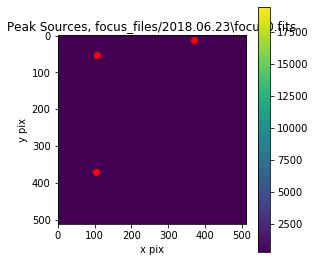

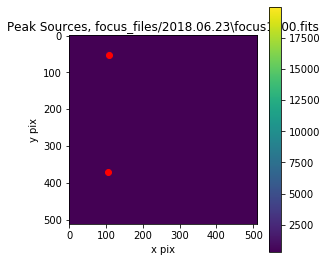

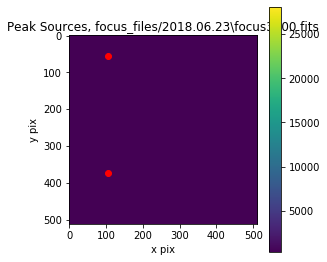

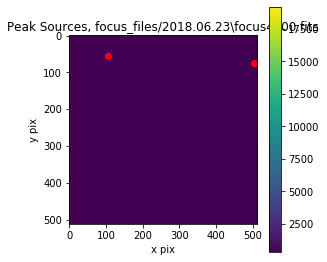

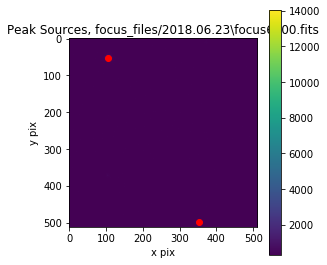

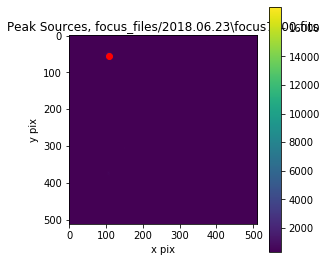

In [71]:
find_centroid('focus_files/2018.06.23/*.fits')

Seems like find_centroid is pulling up the correct amount of stars in the image. Let's stick with this for now and go back to DAOStarFinder soon, since this can calculate flux and other parameters.

We can eventually turn this into a class. For now we are just testing methods.

Now we can make some histograms with our image data.

In [72]:
def peak_histogram(images):
    imlist = glob.glob(images)
    
    for image in imlist:
        data = fits.getdata(image).astype(np.int32)
            
        bkg_sigma = mad_std(data)  # for the threshold calculation, next line
        sources = find_peaks(data=data, threshold=80.*bkg_sigma, box_size=30, centroid_func=centroid_com)  # find the bright sources in the image
        source_counts = sources['peak_value']  # take the flux/counts at each source
        
        hst = np.histogram(source_counts)
        print(hst, image)
        plt.hist(source_counts, bins=8)
        plt.xlabel('Peak Counts')
        plt.ylabel('Frequency')
        plt.show()

(array([2, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64), array([  405. ,  2308.3,  4211.6,  6114.9,  8018.2,  9921.5, 11824.8,
       13728.1, 15631.4, 17534.7, 19438. ])) focus_files/2018.06.23/focus0.fits


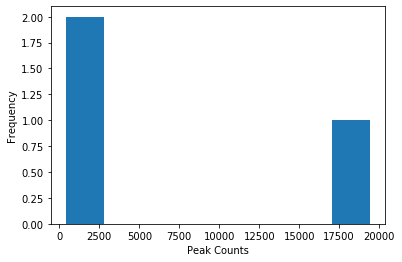

In [73]:
peak_histogram('focus_files/2018.06.23/focus0.fits')

This is a histogram showing the frequency of peak counts in the image. Since there are only 3-ish stars per image the histogram does not have a lot of spread.

We can generalize the cell above to do other types of histograms.

In [74]:
def histogram(images, fwhm, threshold, parameter, bins):
    imlist = glob.glob(images)
    
    for image in imlist:
        data = fits.getdata(image).astype(np.int32)
            
        bkg_sigma = mad_std(data)  # for the threshold calculation, next line
        daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold*bkg_sigma)
        sources = daofind(data)
        
        desired_param = sources[parameter]
        
        hst = np.histogram(desired_param)
        print(hst, image)
        plt.hist(desired_param, bins=bins)
        plt.xlabel(parameter)
        plt.ylabel('Frequency')
        plt.show()

(array([2, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64), array([ 1.58489931,  6.97624932, 12.36759933, 17.75894934, 23.15029935,
       28.54164936, 33.93299937, 39.32434938, 44.71569939, 50.1070494 ,
       55.49839941])) focus_files/2018.06.23/focus0.fits


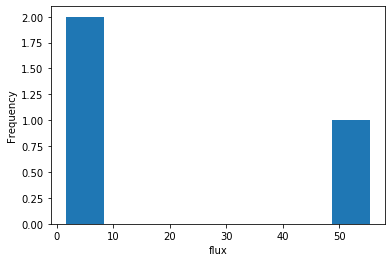

In [75]:
histogram('focus_files/2018.06.23/focus0.fits', 3, 30, 'flux', 8)

This shows a histogram of the fluxes of the bright points in one image.

(array([2, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64), array([0.20299883, 0.22592364, 0.24884845, 0.27177325, 0.29469806,
       0.31762287, 0.34054768, 0.36347249, 0.3863973 , 0.40932211,
       0.43224692])) focus_files/2018.06.23/focus0.fits


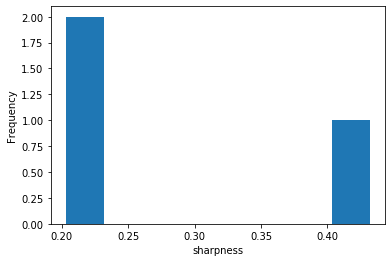

In [76]:
histogram('focus_files/2018.06.23/focus0.fits', 3, 30, 'sharpness', 8)

(array([1, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int64), array([-0.61263902, -0.52404784, -0.43545666, -0.34686549, -0.25827431,
       -0.16968313, -0.08109195,  0.00749923,  0.0960904 ,  0.18468158,
        0.27327276])) focus_files/2018.06.23/focus0.fits


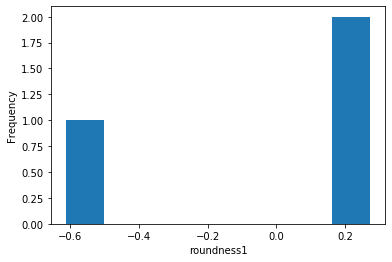

In [77]:
histogram('focus_files/2018.06.23/focus0.fits', 3, 30, 'roundness1', 8)

As shown above, several types of histograms are possible. These may be more interesting as we find images with more stars in them.